In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import itertools
import time
import statsmodels.api as sm
from sklearn import linear_model
from tqdm import tnrange, tqdm_notebook
from sklearn.metrics import mean_squared_error
from statsmodels.regression.quantile_regression import QuantReg

In [3]:
train = pd.read_csv('../data/train/train.csv')
sub = pd.read_csv('../data/sample_submission.csv')

## 전처리

##### 가장 가까운 정보(2일 전 데이터)로 미래를 예측

In [5]:
for i in range(0,81):
    s1 = "test_%d = pd.read_csv('../data/test/%d.csv')"%(i,i)
    exec(s1)

In [7]:
for i in range(0, 1093):
    s1 = "train_%d = pd.concat([train.loc[train['Day'] == %d].reset_index(drop = True), train.loc[train['Day'] == %d + 2].reset_index(drop = True).rename(columns = {'TARGET' : 'TARGET_2'})['TARGET_2']], axis = 1)"%(i, i, i)
    exec(s1)

In [8]:
train_x = pd.concat([train_0, train_1], axis = 0).reset_index(drop=True)
train_x

,Day,Hour,Minute,DHI,DNI,WS,RH,T,TARGET,TARGET_2
0,0,0,0,0,0,1.5,69.08,-12,0.000000,0.000000
1,0,0,30,0,0,1.5,69.06,-12,0.000000,0.000000
2,0,1,0,0,0,1.6,71.78,-12,0.000000,0.000000
3,0,1,30,0,0,1.6,71.75,-12,0.000000,0.000000
4,0,2,0,0,0,1.6,75.20,-12,0.000000,0.000000
5,0,2,30,0,0,1.5,69.29,-11,0.000000,0.000000
6,0,3,0,0,0,1.5,72.56,-11,0.000000,0.000000
7,0,3,30,0,0,1.4,72.55,-11,0.000000,0.000000
8,0,4,0,0,0,1.3,74.62,-11,0.000000,0.000000
9,0,4,30,0,0,1.3,74.61,-11,0.000000,0.000000


In [9]:
for i in range(2, 1093):
    s1 = "train_x = pd.concat([train_x, train_%d], axis = 0).reset_index(drop = True)"%(i)
    exec(s1)

In [10]:
#변수생성
hour_mean = train_x.groupby(['Hour'])['TARGET'].mean()
minute_mean = train_x.groupby(['Minute'])['TARGET'].mean()
train_x['Hour_mean'] = train_x['Hour'].map(hour_mean)
train_x['Minute_mean'] = train_x['Minute'].map(minute_mean)

In [11]:
train_x = train_x.drop(['Day', 'Hour', 'Minute'], axis = 1)
train_x

,DHI,DNI,WS,RH,T,TARGET,TARGET_2,Hour_mean,Minute_mean
0,0,0,1.5,69.08,-12,0.000000,0.000000,0.000000,17.810955
1,0,0,1.5,69.06,-12,0.000000,0.000000,0.000000,17.799137
2,0,0,1.6,71.78,-12,0.000000,0.000000,0.000000,17.810955
3,0,0,1.6,71.75,-12,0.000000,0.000000,0.000000,17.799137
4,0,0,1.6,75.20,-12,0.000000,0.000000,0.000000,17.810955
5,0,0,1.5,69.29,-11,0.000000,0.000000,0.000000,17.799137
6,0,0,1.5,72.56,-11,0.000000,0.000000,0.000000,17.810955
7,0,0,1.4,72.55,-11,0.000000,0.000000,0.000000,17.799137
8,0,0,1.3,74.62,-11,0.000000,0.000000,0.000000,17.810955
9,0,0,1.3,74.61,-11,0.000000,0.000000,0.000000,17.799137


In [12]:
x_train = train_x.drop(['TARGET_2'], axis = 1)
y_train = train_x['TARGET_2']

In [13]:
for i in range(0, 81):
    s1 = "test_%d = test_%d[240:].reset_index(drop = True)"%(i,i)
    s2 = "hour_mean = test_%d.groupby(['Hour'])['TARGET'].mean()"%(i)
    s3 = "minute_mean = test_%d.groupby(['Minute'])['TARGET'].mean()"%(i)
    s4 = "test_%d['Hour_mean'] = test_%d['Hour'].map(hour_mean)"%(i,i)
    s5 = "test_%d['Minute_mean'] = test_%d['Minute'].map(minute_mean)"%(i,i)
    s6 = "test_%d = test_%d.drop(['Day', 'Hour', 'Minute'], axis = 1)"%(i,i)
    exec(s1)
    exec(s2)
    exec(s3)
    exec(s4)
    exec(s5)
    exec(s6)

In [14]:
test_x = pd.concat([test_0, test_1], axis = 0).reset_index(drop=True)
test_x

,DHI,DNI,WS,RH,T,TARGET,Hour_mean,Minute_mean
0,0,0,2.1,52.83,-4.4,0.000000,0.000000,6.061008
1,0,0,2.0,54.44,-4.8,0.000000,0.000000,5.926100
2,0,0,1.9,52.78,-5.1,0.000000,0.000000,6.061008
3,0,0,1.8,53.59,-5.3,0.000000,0.000000,5.926100
4,0,0,1.7,52.63,-5.5,0.000000,0.000000,6.061008
5,0,0,1.6,52.63,-5.5,0.000000,0.000000,5.926100
6,0,0,1.5,53.11,-5.6,0.000000,0.000000,6.061008
7,0,0,1.4,52.71,-5.5,0.000000,0.000000,5.926100
8,0,0,1.3,53.63,-5.5,0.000000,0.000000,6.061008
9,0,0,1.2,53.23,-5.4,0.000000,0.000000,5.926100


In [15]:
for i in range(2, 81):
    s1 = "test_x = pd.concat([test_x, test_%d], axis = 0).reset_index(drop = True)"%(i)
    exec(s1)

In [16]:
x_test = test_x.copy()

### 변수선택(best subest)

In [29]:
import math

In [30]:
x_train['GHI'] = x_train['DNI']*math.cos(math.pi/180*63)+x_train['DHI']
x_test['GHI'] = x_test['DNI']*math.cos(math.pi/180*63)+x_test['DHI']
x_train = x_train.drop(['DHI', 'DNI', 'Hour_mean', 'Minute_mean'], axis = 1)
x_test = x_test.drop(['DHI', 'DNI', 'Hour_mean', 'Minute_mean'], axis = 1)

In [34]:
def linear_reg(X,y):
    model = linear_model.LinearRegression(fit_intercept = True)
    model.fit(X,y)
    RSS = mean_squared_error(y,model.predict(X)) * len(y)
    R_squared = model.score(X,y)
    return RSS, R_squared

#X변수 개수
m = len(y_train)
k = 5
RSS_list, R_squared_list, feature_list = [],[], []
numb_features = []

#1 ~ 5까지 모든 조합에 대한 성능 테스트(RSS, R_Squared)
for k in tnrange(1,len(x_train.columns) + 1):
    for combo in itertools.combinations(x_train.columns,k):
        tmp_result = linear_reg(x_train[list(combo)],y_train)  
        RSS_list.append(tmp_result[0])              
        R_squared_list.append(tmp_result[1])
        feature_list.append(combo)
        numb_features.append(len(combo))   

#결과
df = pd.DataFrame({'numb_features': numb_features,'RSS': RSS_list, 'R_squared':R_squared_list,'features':feature_list})

<ipython-input-34-78056cb1ffc9>:15: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for k in tnrange(1,len(x_train.columns) + 1):


In [35]:
df['min_RSS'] = df.groupby('numb_features')['RSS'].transform(min)
df['max_R_squared'] = df.groupby('numb_features')['R_squared'].transform(max)
df

,numb_features,RSS,R_squared,features,min_RSS,max_R_squared
0,1,3.281036e+07,0.058496,"(WS,)",1.154767e+07,0.668636
1,1,2.265496e+07,0.349909,"(RH,)",1.154767e+07,0.668636
2,1,2.578791e+07,0.260008,"(T,)",1.154767e+07,0.668636
3,1,1.154767e+07,0.668636,"(TARGET,)",1.154767e+07,0.668636
4,1,1.320328e+07,0.621128,"(GHI,)",1.154767e+07,0.668636
5,2,2.224208e+07,0.361756,"(WS, RH)",1.141809e+07,0.672354
6,2,2.397937e+07,0.311904,"(WS, T)",1.141809e+07,0.672354
7,2,1.146695e+07,0.670952,"(WS, TARGET)",1.141809e+07,0.672354
8,2,1.315729e+07,0.622447,"(WS, GHI)",1.141809e+07,0.672354
9,2,2.081295e+07,0.402765,"(RH, T)",1.141809e+07,0.672354


In [36]:
df_min = df[df.groupby('numb_features')['RSS'].transform(min) == df['RSS']]
display(df_min.head(5))

,numb_features,RSS,R_squared,features,min_RSS,max_R_squared
3,1,1.154767e+07,0.668636,"(TARGET,)",1.154767e+07,0.668636
12,2,1.141809e+07,0.672354,"(T, TARGET)",1.141809e+07,0.672354
18,3,1.130605e+07,0.675569,"(WS, T, TARGET)",1.130605e+07,0.675569
28,4,1.124335e+07,0.677368,"(WS, T, TARGET, GHI)",1.124335e+07,0.677368
30,5,1.122679e+07,0.677843,"(WS, RH, T, TARGET, GHI)",1.122679e+07,0.677843


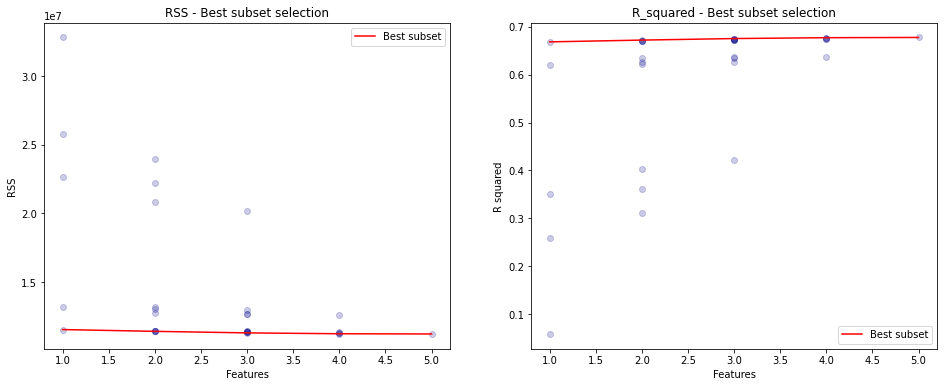

In [37]:
fig = plt.figure(figsize = (16,6))
ax = fig.add_subplot(1, 2, 1)

ax.scatter(df.numb_features,df.RSS, alpha = .2, color = 'darkblue' )
ax.plot(df.numb_features,df.min_RSS,color = 'r', label = 'Best subset')
ax.set_xlabel('Features')
ax.set_ylabel('RSS')
ax.set_title('RSS - Best subset selection')
ax.legend()

ax = fig.add_subplot(1, 2, 2)
ax.scatter(df.numb_features,df.R_squared, alpha = .2, color = 'darkblue' )
ax.plot(df.numb_features,df.max_R_squared,color = 'r', label = 'Best subset')
ax.set_xlabel('Features')
ax.set_ylabel('R squared')
ax.set_title('R_squared - Best subset selection')
ax.legend()

plt.show()

In [39]:
sub['q_0.1'] = QuantReg(y_train, x_train['GHI']).fit(q=0.1).predict(x_test['TARGET'])
sub['q_0.2'] = QuantReg(y_train, x_train['TARGET']).fit(q=0.2).predict(x_test['TARGET'])
sub['q_0.3'] = QuantReg(y_train, x_train['TARGET']).fit(q=0.3).predict(x_test['TARGET'])
sub['q_0.4'] = QuantReg(y_train, x_train['TARGET']).fit(q=0.4).predict(x_test['TARGET'])
sub['q_0.5'] = QuantReg(y_train, x_train['TARGET']).fit(q=0.5).predict(x_test['TARGET'])
sub['q_0.6'] = QuantReg(y_train, x_train['TARGET']).fit(q=0.6).predict(x_test['TARGET'])
sub['q_0.7'] = QuantReg(y_train, x_train['TARGET']).fit(q=0.7).predict(x_test['TARGET'])
sub['q_0.8'] = QuantReg(y_train, x_train['TARGET']).fit(q=0.8).predict(x_test['TARGET'])
sub['q_0.9'] = QuantReg(y_train, x_train['TARGET']).fit(q=0.9).predict(x_test['TARGET'])

In [40]:
sub.to_csv('target_lr.csv', index = False)